In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import cf
# import cfplot as cfp
import xclim
import pandas as pd
import netCDF4

from nc_processing import *
from analysis import * 

%matplotlib inline

## First, let's specify some settings for all the models

In [2]:
test_dir='/badc/cmip6/data/CMIP6/GeoMIP/NCAR/CESM2-WACCM/G6sulfur/r1i1p1f2/day/pr/gn/latest/'
test_file='pr_day_CESM2-WACCM_G6sulfur_r1i1p1f2_gn_20600102-20700101.nc'

xr.open_dataset(test_dir + test_file).time

# UKESM1 - 360-day, 2 GeoMIP files, daily there
# CNRM-ESM2-1 - 365-day, 1 GeoMIP file, daily there
# IPSL-CM6A-LR - 365-day, 1 GeoMIP file, daily there
# MPI-ESM-2-HR - 365-day, LOTS of files
# MPI-ESM-2-LR - 365-day, 5 files, daily there
# CESM2-WACCM - 365-day (no-leap), 9 files, daily T and P only


<xarray.DataArray 'time' (time: 3647)>
array([cftime.DatetimeNoLeap(2060, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2060, 1, 3, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2060, 1, 4, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2069, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2069, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2070, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2060-01-02 00:00:00 ... 2070-01-01 00:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
    title:          time
    type:           double

In [3]:
# Some general settings:
average_period = 30 # 30 years

# let's store all the model-specific details in dictionaries

project_dict = {'historical':'CMIP',
                'ssp245':'ScenarioMIP',
                'ssp585':'ScenarioMIP',
                'G6solar':'GeoMIP',
                'G6sulfur':'GeoMIP',}

centre_dict = {'CESM2-WACCM':'NCAR',
               'IPSL-CM6A-LR':'IPSL',
               #'MPI-ESM1-2-HR':'MPI-M', # this model doesn't have the SSP scenarios
               'MPI-ESM1-2-LR':'MPI-M',
               'UKESM1-0-LL':'MOHC',}

grid_dict = {'CESM2-WACCM':'gn',
             'IPSL-CM6A-LR':'gr',
             #'MPI-ESM1-2-HR':'gn', # this model doesn't have the SSP scenarios
             'MPI-ESM1-2-LR':'gn',
             'UKESM1-0-LL':'gn',}

# dates for models
historical_UKESM = ['1960-01-01','1989-12-30'] # UKESM has 30-day months
historical_other = ['1960-01-01','1989-12-31'] # others have normal months
future_UKESM = ['2070-01-01','2099-12-30']
future_other = ['2070-01-01','2099-12-31']

# Let's find all the runs for all of the model / experiment combinations:

run_dict = {} # to store the list of runs for each combination
years_dict = {}
dates_dict = {}

# each experiment for each model may have different runs, so we loop over all combinations.
for model in centre_dict.keys():
    for exp in project_dict.keys():
        
        # Specify the directory just above where the runs are stored, so we can check what's in it.
        run_dir='/badc/cmip6/data/CMIP6/{project}/{centre}/{model}/{exp}/'.format(model=model, centre=centre_dict[model], exp=exp, project=project_dict[exp])
        
        # This try / except structure catches errors and rather than crashing does something.
        try:
            # os.listdir() lists the content of a directory, they stuff around it screens out all non-directory results (isdir() checks if its a directory)
            run_dirs = [ name for name in os.listdir(run_dir) if os.path.isdir(os.path.join(run_dir, name)) ]
            # store the resulting list of runs in our dictionary.
            run_dict[model,exp] = run_dirs
            years_dict[model,exp] = average_period * len(run_dirs)
        # If an error is found let's print it out
        except FileNotFoundError as error:
            print(model,exp)
            print(error)
            run_dict[model,exp] = None # None is a special "empty" type of variable.
            years_dict[model,exp] = None
        
        # Now fill dates_dict
        if exp == 'historical':
            if model == 'UKESM1-0-LL':
                dates_dict[model,exp] = historical_UKESM
            else:
                dates_dict[model,exp] = historical_other
        else:
            if model == 'UKESM1-0-LL':
                dates_dict[model,exp] = future_UKESM
            else:
                dates_dict[model,exp] = future_other
        
    #end exp loop
#end model loop

In [4]:
def model_exp_settings_func(historical_years=[1960,1989], future_years=[2070,2099]):
    """
    Returns a dictionary of all combinations of model-exp specific settings for the given year range for use in processing functions
    
    # years are inclusive, i.e. specifying jan 1st 1960 to dec 31st 1989.
    """
   
    # intermediate dictionaries.
    project_dict = {'historical':'CMIP',
                    'ssp245':'ScenarioMIP',
                    'ssp585':'ScenarioMIP',
                    'G6solar':'GeoMIP',
                    'G6sulfur':'GeoMIP',}

    centre_dict = {'CESM2-WACCM':'NCAR',
                   'IPSL-CM6A-LR':'IPSL',
                   #'MPI-ESM1-2-HR':'MPI-M', # this model doesn't have the SSP scenarios
                   'MPI-ESM1-2-LR':'MPI-M',
                   'UKESM1-0-LL':'MOHC',}

    grid_dict = {'CESM2-WACCM':'gn',
                 'IPSL-CM6A-LR':'gr',
                 #'MPI-ESM1-2-HR':'gn', # this model doesn't have the SSP scenarios
                 'MPI-ESM1-2-LR':'gn',
                 'UKESM1-0-LL':'gn',}

    # dates for models
    historical_UKESM = [str(historical_years[0])+'-01-01',str(historical_years[1])+'-12-30'] # UKESM has 30-day months
    historical_other = [str(historical_years[0])+'-01-01',str(historical_years[1])+'-12-31'] # others have normal months
    future_UKESM = [str(future_years[0])+'-01-01',str(future_years[1])+'-12-30']
    future_other = [str(future_years[0])+'-01-01',str(future_years[1])+'-12-31']

    # Let's find all the runs for all of the model / experiment combinations:

    run_dict = {} # to store the list of runs for each combination
    years_dict = {}
    dates_dict = {}

    # each experiment for each model may have different runs, so we loop over all combinations.
    for model in centre_dict.keys():
        for exp in project_dict.keys():

            # Specify the directory just above where the runs are stored, so we can check what's in it.
            run_dir='/badc/cmip6/data/CMIP6/{project}/{centre}/{model}/{exp}/'.format(model=model, centre=centre_dict[model], exp=exp, project=project_dict[exp])

            # This try / except structure catches errors and rather than crashing does something.
            try:
                # os.listdir() lists the content of a directory, they stuff around it screens out all non-directory results (isdir() checks if its a directory)
                run_dirs = [ name for name in os.listdir(run_dir) if os.path.isdir(os.path.join(run_dir, name)) ]
                # store the resulting list of runs in our dictionary.
                run_dict[model,exp] = run_dirs
                years_dict[model,exp] = average_period * len(run_dirs)
            # If an error is found let's print it out
            except FileNotFoundError as error:
                print(model,exp)
                print(error)
                run_dict[model,exp] = None # None is a special "empty" type of variable.
                years_dict[model,exp] = None

            # Now fill dates_dict
            if exp == 'historical':
                if model == 'UKESM1-0-LL':
                    dates_dict[model,exp] = historical_UKESM
                else:
                    dates_dict[model,exp] = historical_other
            else:
                if model == 'UKESM1-0-LL':
                    dates_dict[model,exp] = future_UKESM
                else:
                    dates_dict[model,exp] = future_other

        #end exp loop
    #end model loop
    
    model_exp_settings_dict = {}
    
    for model in centre_dict.keys():
        for exp in project_dict.keys():
            
            settings_dict = {}
            settings_dict['project'] = project_dict[exp]
            settings_dict['centre'] = centre_dict[model]
            settings_dict['grid'] = grid_dict[model]
            settings_dict['dates'] = dates_dict[model,exp]
            settings_dict['runs'] = run_dict[model,exp]
            settings_dict['total_run_years'] = years_dict[model,exp]
            
            model_exp_settings_dict[model,exp] = settings_dict
    
    # Return the settings
    return model_exp_settings_dict

In [5]:
model_exp_settings_dict = model_exp_settings_func()

In [6]:
# Make some adjustments:

# Some IPSL historical runs missing for some variables:
model_exp_settings_dict['IPSL-CM6A-LR','historical']['runs'] = ['r1i1p1f1','r2i1p1f1','r3i1p1f1','r4i1p1f1','r5i1p1f1','r6i1p1f1','r7i1p1f1','r8i1p1f1','r9i1p1f1']
model_exp_settings_dict['MPI-ESM1-2-LR','historical']['runs'] = ['r1i1p1f1']
model_exp_settings_dict['MPI-ESM1-2-LR','ssp245']['runs'] = ['r1i1p1f1']#,'r2i1p1f1','r3i1p1f1']
model_exp_settings_dict['MPI-ESM1-2-LR','ssp585']['runs'] = ['r1i1p1f1']#,'r2i1p1f1','r3i1p1f1']

# Let's calculate some efficacy metric stuff for precipitation


In [7]:
"""
Now I create some dictionaries to group together terms, i.e. variables with their "domains", and experiments with their project and time-average period.
"""

data_dir='/home/users/pjirvine/data/' # !!!!!!!!!!!!! CHANGE THIS !!!!!!!!!!!!!!!!!!

# # the t-test needs to know how long our sample is.
num_years = 90 
p_thresh = 0.05 # for 95% T-Test

season = 'ANN'

model_list = ['MPI-ESM1-2-LR','UKESM1-0-LL'] 
                #'CESM2-WACCM' - timeslice issue on G6sulfur but not other exps:
                    # KeyError: cftime.DatetimeNoLeap(2070, 1, 1, 0, 0, 0, 0, has_year_zero=True)
                #'MPI-ESM1-2-HR' - this model doesn't have the SSP scenarios
                #'IPSL-CM6A-LR' - timeslice issue on ssp585 but not other exps:
                    # TypeError: '<' not supported between instances of 'cftime._cftime.DatetimeGregorian' and 'str'

"""
Fix for CESM2-WACCM to use in tslice function
    # CESM2-WACCM has duplicate files for G6sulfur, which messes up the calculations.
    if model == 'CESM2-WACCM' and exp == 'G6sulfur' and var == 'tas':
        file_list=['tas_Amon_CESM2-WACCM_G6sulfur_r1i1p1f2_gn_202001-206912.nc',
                   'tas_Amon_CESM2-WACCM_G6sulfur_r1i1p1f2_gn_207001-210012.nc']
"""
                    
exp_list = ['historical','ssp245','ssp585','G6sulfur','G6solar']

var_settings_dict = {'tas':'Amon', # Make sure that tas is included and is first as it's used to normalize everything else.
                     'pr':'Amon',
                     #'sfcWind':'Amon',
                     #'psl':'Amon',
                    }

In [8]:
model = 'UKESM1-0-LL'
exp = 'G6sulfur'
var = 'tas'

# Now I unpack the values stored in the model_exp_settings_dict
project = model_exp_settings_dict[model,exp]['project']
centre = model_exp_settings_dict[model,exp]['centre']
grid = model_exp_settings_dict[model,exp]['grid']
dates = model_exp_settings_dict[model,exp]['dates']
runs = model_exp_settings_dict[model,exp]['runs']

domain = 'day'

ds_mean, ds_std = get_ens_seasonal_mean_std(season, dates, data_dir, model, centre, var, domain, exp, project, runs, grid, stat='max')

loading existing files tas_day_UKESM1-0-LL_G6sulfur_ens-mean_gn_2070-01-01_2099-12-30 ANN max


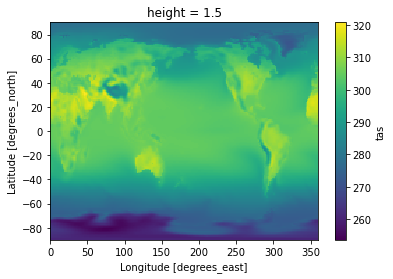

In [9]:
ds_mean[var].plot()

In [10]:
ds_mean, ds_std = get_ens_seasonal_mean_std(season, dates, data_dir, model, centre, var, domain, exp, project, runs, grid, stat='min')

loading existing files tas_day_UKESM1-0-LL_G6sulfur_ens-mean_gn_2070-01-01_2099-12-30 ANN min


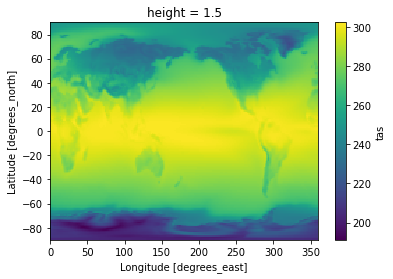

In [11]:
ds_mean[var].plot()

# Now, I'm going to wrap the code which got all the means and standard deviations in the full_figure_example into a loop that enters the data into a dictionary. 

In [12]:
# Create an empty dictionary to store the data
data_dict = {}

for model in model_list:

    # Loop over all variables, catching the "domain" value stored in the var_settings_dict
    for var, domain in var_settings_dict.items():

        # Loop over all experiments, catching the settings stored in exp_settings_dict
        for exp in exp_list:

            # Now I unpack the values stored in the model_exp_settings_dict
            project = model_exp_settings_dict[model,exp]['project']
            centre = model_exp_settings_dict[model,exp]['centre']
            grid = model_exp_settings_dict[model,exp]['grid']
            dates = model_exp_settings_dict[model,exp]['dates']
            runs = model_exp_settings_dict[model,exp]['runs']

            # get the mean and standard deviation using get_ens_seasonal_mean_std()
            # all the inputs needed for the function have been specified above except for:
            # VAR and DOMAIN which are specified by the outer for loop, and
            # EXP, PROJECT and DATES which are specified by the inner for loop
            ds_mean, ds_std = get_ens_seasonal_mean_std(season, dates, data_dir, model, centre, var, domain, exp, project, runs, grid)

            # Here the "key" for the dictionary has 3 parts: var, exp, and then 'mean' or 'std'
            data_dict[model, var, exp, 'mean'] = ds_mean[var]
            data_dict[model, var, exp, 'std'] = ds_std[var]

        # end for exp

    #end for exp

"""
Now we have a dictionary where every item is a data array
"""

loading existing files tas_Amon_MPI-ESM1-2-LR_historical_ens-mean_gn_1960-01-01_1989-12-31 ANN mean
loading existing files tas_Amon_MPI-ESM1-2-LR_ssp245_ens-mean_gn_2070-01-01_2099-12-31 ANN mean
loading existing files tas_Amon_MPI-ESM1-2-LR_ssp585_ens-mean_gn_2070-01-01_2099-12-31 ANN mean
loading existing files tas_Amon_MPI-ESM1-2-LR_G6sulfur_ens-mean_gn_2070-01-01_2099-12-31 ANN mean
loading existing files tas_Amon_MPI-ESM1-2-LR_G6solar_ens-mean_gn_2070-01-01_2099-12-31 ANN mean
loading existing files pr_Amon_MPI-ESM1-2-LR_historical_ens-mean_gn_1960-01-01_1989-12-31 ANN mean
loading existing files pr_Amon_MPI-ESM1-2-LR_ssp245_ens-mean_gn_2070-01-01_2099-12-31 ANN mean
loading existing files pr_Amon_MPI-ESM1-2-LR_ssp585_ens-mean_gn_2070-01-01_2099-12-31 ANN mean
loading existing files pr_Amon_MPI-ESM1-2-LR_G6sulfur_ens-mean_gn_2070-01-01_2099-12-31 ANN mean
loading existing files pr_Amon_MPI-ESM1-2-LR_G6solar_ens-mean_gn_2070-01-01_2099-12-31 ANN mean
loading existing files tas_Amon

'\nNow we have a dictionary where every item is a data array\n'

#### Note it's easy enough to wrap this with another loop, e.g. for models (though some settings will depend on both model and exp), and to extend it to include hundreds of variables, BUT you will eventually run out of space. The right level of wrapping / looping will depend on your application.

### now let's access one entry and check it looks right by specifying the variable, experiment and the output that we want

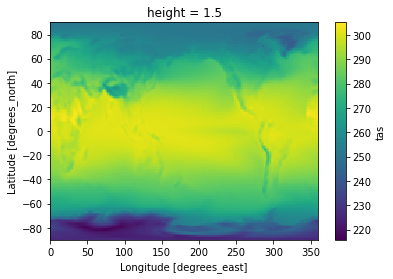

In [14]:
# We extract the data we want by specifying the: variable, experiment, and statistic we want.
data_dict['UKESM1-0-LL','tas','historical','mean'].plot() # it'll plot as it's a data array

In [16]:
"""
Let's get the area and land area for UKESM
"""

# Use the get_fixed() function to return the gridcell area and land fraction for the model we want.
ds_area, ds_land = get_fixed('MOHC','UKESM1-0-LL') 
# Let's define a data array for the area weight of the gridcells
da_weight = ds_area['areacella'] / ds_area['areacella'].sum()
da_weight = da_weight.rename(new_name_or_name_dict='area_weight') # we don't really need to do this but why not.
# now if we inspect the da_weight variable we'll see that it's a data array containing a variable: "area_weight"

# now for land area
da_land_area = ds_area['areacella'] * ds_land['sftlf'] * 0.01 # 0.01 is needed as land fraction is a percentage
da_land_weight = da_land_area / da_land_area.sum()
da_land_weight = da_land_weight.rename(new_name_or_name_dict='land_area_weight')

# now let's do a land mask, 
da_land_1_mask = ds_land['sftlf'] > 1 # we'll be generous and count any place with >1% land in a grid cell
da_land_50_mask = ds_land['sftlf'] > 50 # 50%
da_land_99_mask = ds_land['sftlf'] > 99 # 99%

## TO DO add +/- 66.3 mask so that Antarctic and Arctic are excluded.

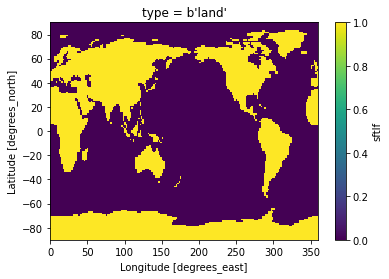

In [17]:
da_land_50_mask.plot()

The land mask looks good.

In [18]:
"""
Now, let's calculate some anomalies and store them in dictionaries so we can easily access them later.

half-converted to multi-model analysis. need to convert anom_dicts..
"""

# This is our list of anomalies, 1st - 2nd:       # I'm only getting the anomalies I need for this analysis but you can extend it easily for your use.
anom_list = [('ssp585','historical'), # SSP5-8.5 - historical
             ('ssp245','ssp585'), # etc.
             ('G6sulfur','ssp585'),
             ('G6solar','ssp585'),
            ]

# First let's set up a list of empty dictionaries to store all the results
global_anom_dict, anom_data_dict, norm_anom_data_dict, SD_norm_anom_data_dict = {}, {}, {}, {} # does same thing as 4 lines of X = {}

# Now we loop through variables and our pairs of experiments to calculate our anomalies
for var in var_settings_dict.keys():
    for exp_1, exp_2 in anom_list:
        
        # First let's do a global area-weighted mean, saving a single value in the dictionary:
        global_anom_dict[(var,exp_1,exp_2)] = ((data_dict[model,var,exp_1,'mean'] - data_dict[model,var,exp_2,'mean']) * da_weight).sum().values
        # Second let's calculate the anomaly between the 2 data arrays for the experiments and variable we've specified:
        anom_data_dict[(var,exp_1,exp_2)] = data_dict[model,var,exp_1,'mean'] - data_dict[model,var,exp_2,'mean']
        # Third, let's calculate the global-mean-temperature normalized anomaly using those 2 previous calculations:
        norm_anom_data_dict[(var,exp_1,exp_2)] = anom_data_dict[(var,exp_1,exp_2)] / global_anom_dict[(var,exp_1,exp_2)]
        # Finally, let's calculate the anomalies normalized by both temperature change (in absolute terms) and control standard deviations:
        SD_norm_anom_data_dict[(var,exp_1,exp_2)] = (anom_data_dict[(var,exp_1,exp_2)] / data_dict[model,var,'historical','std']) / abs(global_anom_dict[('tas',exp_1,exp_2)])
        
    # endfor anom_list
# endfor var

### Note to self, a more elegant way to do this would be like my get_data() function which either calculates then saves the data or just loads a previously saved result.

#### OK, that's a little clunky, I'll come back later and wrap it up in a few loops and save the data into a new dictionary to make it more compact + sensible.

In [31]:
"""
Let's set up our data - we're using the anomalies measured in control standard deviations, normalized by global-mean temperature
"""

# 'tas''pr''sfcWind''psl'

exp = 'G6sulfur' 
var = 'pr'

# Global-mean temperature anomalies
GW_T = global_anom_dict[('tas','ssp585','historical')]
SG_T = global_anom_dict[('tas',exp,'ssp585')]

"""
Connor - Replace the 2 lines below to instead load up the particular extreme index you want to plot.
Keep the GW_array and SG_array variable names and make sure that you feed them numpy arrays and not xarrays.

Here's what i did, and you'll need to do something similar:

SG_array = ((g6sulfur_mean - ssp585_mean) / historical_std) / abs(SG_T)
same for GW_array but ssp585 - historical

You'll have to combine the panels offline if you want more than one at a time as I don't have time to completely reformat the code below right now.
plus change any label stuff below where it actually plots.
"""
# Let's rename these to something generic so it'll be easier to turn this into a generalizable function.
GW_array = SD_norm_anom_data_dict[(var,'ssp585','historical')] 
SG_array = -1. * SD_norm_anom_data_dict[(var,exp,'ssp585')] # Now it has the same sign as ssp585 anomaly

"""
This is where the function would start...
"""

# First we "flatten" the data arrays, pancaking the data into a single dimension as some functions need to read it this way. 
# This happens in the same way for every array so despite losing 1 dimension,
# Every value in position N in every array will still refer to the same point.
GW_flat = GW_array.values.flatten()
SG_flat = SG_array.values.flatten()
eff_flat = SG_flat / GW_flat

# Let's do the weights and masks too.
area_weight = da_weight.values.flatten()
land_weight = da_land_weight.values.flatten()
land_50_mask = da_land_50_mask.values.flatten()

In [32]:
"""
Find the threhold level of T-test passing in standard deviations
"""
num_steps = 1000

ttest_sds = None
for IDX in [idx / num_steps for idx in range(num_steps)]:
    if ttest_sds is None:
        if ttest_sub(IDX, 1, num_years, 0, 1, num_years, equal_var=True) < p_thresh:
            ttest_sds = IDX
"""
Normalize threshold by change in temperature under solar geo so test applies to normalized data.
"""        
ttest_sds_orig = ttest_sds / abs(SG_T)
ttest_sds_orig

0.1388645136050009

In [33]:
"""
Sort the global warming anomaly from most negative (or smallest) to most positive, and bin it into 100 percentiles (pctl) or 1000 milltiles (mltls),
and then bin the solar geo and efficacy data using these global warming bins.

All the solar geo and efficacy data for the same percentile of the global warming anomaly are now together.
This allows us to analyse these metrics as a function of the global warming percentiles.
"""

# Now, let's define the percentile and milltile (1000) bounds and centres
# 0-1 in 1%
percentile_bounds = [(idx+1) / 100. for idx in range(99)] # 1 - 99
percentile_centres = [(idx+0.5) / 100. for idx in range(100)] # 0.5 - 99.5

# 0-1 in 0.1%
milltile_bounds = [(idx+1) / 1000. for idx in range(999)] # 1 - 999
milltile_centres = [(idx+0.5) / 1000. for idx in range(1000)] # 0.5 - 999.5

# XXX_pctl_data = a list of 100 arrays with all data points that fall in each percentile of global warming anomaly.
GW_pctl_data, GW_pctl_frac = sort_data_distribution(GW_flat, GW_flat, percentile_bounds, distribution=True)
SG_pctl_data, SG_pctl_frac = sort_data_distribution(SG_flat, GW_flat, percentile_bounds, distribution=True)
eff_pctl_data, eff_pctl_frac = sort_data_distribution(eff_flat, GW_flat, percentile_bounds, distribution=True)

# XXX_mltl_data as above for 1000 milltiles.
GW_mltl_data, GW_mltl_frac = sort_data_distribution(GW_flat, GW_flat, milltile_bounds, distribution=True)
SG_mltl_data, SG_mltl_frac = sort_data_distribution(SG_flat, GW_flat, milltile_bounds, distribution=True)
eff_mltl_data, eff_mltl_frac = sort_data_distribution(eff_flat, GW_flat, milltile_bounds, distribution=True)

In [34]:
"""
Now we stick the percentile chunks back together in percentile order.

NOTE - The data is sorted into percentiles / milltiles but does not perfectly match, 
i.e. individual gridpoints no longer have perfectly matching indices in these arrays.
This is OK for plotting at the percentile / milltile level but not for point-wise calculations. 
"""
GW_pctl_data_concat = np.concatenate(GW_pctl_data)
SG_pctl_data_concat = np.concatenate(SG_pctl_data)
eff_pctl_data_concat = np.concatenate(eff_pctl_data)

GW_mltl_data_concat = np.concatenate(GW_mltl_data)
SG_mltl_data_concat = np.concatenate(SG_mltl_data)
eff_mltl_data_concat = np.concatenate(eff_mltl_data)

# Now we create an array where the values for each point show which percentile it belongs too.
mltls_for_data_concat = np.concatenate([milltile_centres[IDX] * np.ones_like(GW_mltl_data[IDX]) for IDX in range(len(milltile_centres))])
pctls_for_data_concat = np.concatenate([percentile_centres[IDX] * np.ones_like(GW_pctl_data[IDX]) for IDX in range(len(percentile_centres))])

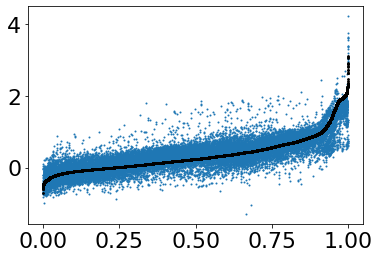

In [35]:
"""
Let's test that our data has been sorted, plotting all anomalies sorted by GW milltiles
"""
plt.scatter(mltls_for_data_concat, SG_mltl_data_concat, s=1)
plt.scatter(mltls_for_data_concat, GW_mltl_data_concat, color='k', s=3)

#### Great, the black line shows that the GW results are sorted from smallest to largest, whereas the blue dots show the range of SG results as a function of the GW data.

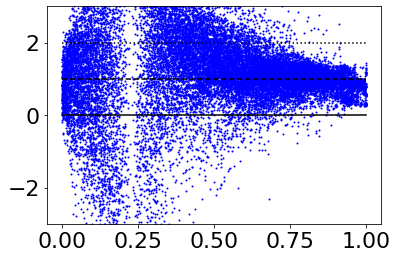

In [36]:
plt.scatter(mltls_for_data_concat, eff_mltl_data_concat, color='b', s=1)
plt.ylim(-3,3)
plt.plot([0,1],[0,0], color='k')
plt.plot([0,1],[1,1], color='k', linestyle='dashed')
plt.plot([0,1],[2,2], color='k', linestyle='dotted')

In [37]:
# sort_data_distribution(GW_flat, GW_flat, percentile_bounds, distribution=True)

plot_pctl_bounds = [0.05,0.25,0.5,0.75,0.95]

GW_pctl_data_plot_pctls = [weighted_quantile(IDX, plot_pctl_bounds) for IDX in GW_pctl_data]
SG_pctl_data_plot_pctls = [weighted_quantile(IDX, plot_pctl_bounds) for IDX in SG_pctl_data]
eff_pctl_data_plot_pctls = [weighted_quantile(IDX, plot_pctl_bounds) for IDX in eff_pctl_data]

GW_mltl_data_plot_pctls = [weighted_quantile(IDX, plot_pctl_bounds) for IDX in GW_mltl_data]
SG_mltl_data_plot_pctls = [weighted_quantile(IDX, plot_pctl_bounds) for IDX in SG_mltl_data]
eff_mltl_data_plot_pctls = [weighted_quantile(IDX, plot_pctl_bounds) for IDX in eff_mltl_data]

In [38]:
def find_first_value(sorted_data, value):
    # Finds the first occurence of a given value for data sorted from low to high
    sign = np.sign(sorted_data - value)
    signchange = ((np.roll(sign, 1) - sign) != 0).astype(int)
    sign_where = np.where(signchange == 1)
    if sign_where[0].size == 0:
        return None
    else:
        return sign_where[0][1]

# Find the medians for the global warming milltiles
GW_mltl_data_medians = np.array([np.median(IDX) for IDX in GW_mltl_data])

# Find the first milltile where the anomaly exceeds zero plus or minus the t-test threshold.
zero_pctl, ttest_neg_pctl, ttest_pos_pctl = None, None, None
if find_first_value(GW_mltl_data_medians, 0) is not None:
    zero_pctl = milltile_centres[find_first_value(GW_mltl_data_medians, 0)]
if find_first_value(GW_mltl_data_medians, -1.*ttest_sds_orig) is not None:
    ttest_neg_pctl = milltile_centres[find_first_value(GW_mltl_data_medians, -1.*ttest_sds_orig)]
if find_first_value(GW_mltl_data_medians, ttest_sds_orig) is not None:
    ttest_pos_pctl = milltile_centres[find_first_value(GW_mltl_data_medians, ttest_sds_orig)]

In [39]:
int(zero_pctl * 1000)

227

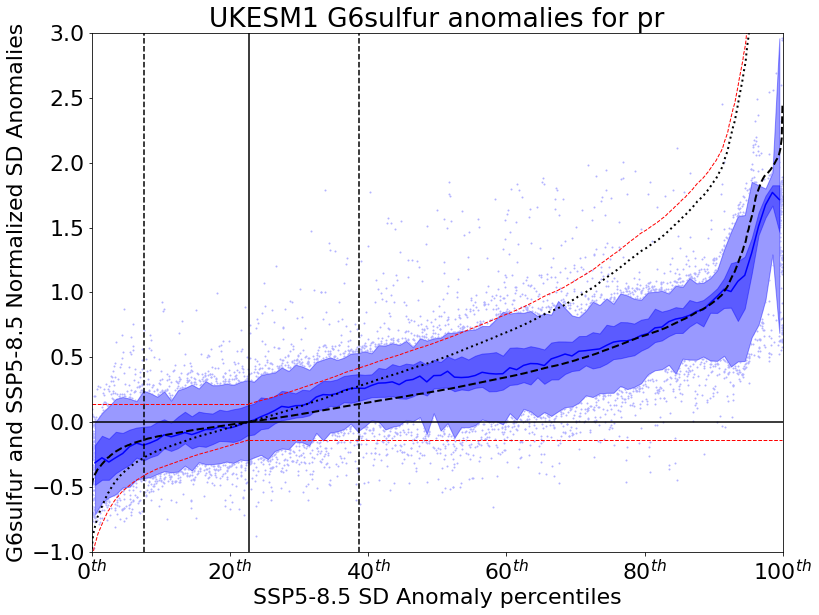

In [40]:
fig = plt.figure(1, figsize=(12, 9))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

plt.rcParams.update({'font.size': 22})

# Plot all SG anomalies on basis of GW milltiles.
plt.scatter(mltls_for_data_concat, SG_mltl_data_concat, s=1, color=(0.7, 0.7, 1.0))

# Plot 5-95%ile range of SG response per percentile
plot_5th = np.array([INNER[0] for INNER in SG_pctl_data_plot_pctls])
plot_95th = np.array([INNER[4] for INNER in SG_pctl_data_plot_pctls])
plt.fill_between(percentile_centres, plot_5th, plot_95th, color='w') # blot out dots to prevent overlapping
plt.fill_between(percentile_centres, plot_5th, plot_95th, color='b', alpha=0.4)
# Plot 25-75%ile range of SG response per percentile
plot_25th = np.array([INNER[1] for INNER in SG_pctl_data_plot_pctls])
plot_75th = np.array([INNER[3] for INNER in SG_pctl_data_plot_pctls])
plt.fill_between(percentile_centres, plot_25th, plot_75th, color='b', alpha=0.4)
# plot median SG response per percentile
plot_50th = np.array([INNER[2] for INNER in SG_pctl_data_plot_pctls])
plt.plot(percentile_centres, plot_50th, color='b')

# Plot a horizonal zero line
plt.plot([0,1],[0,0],color='k')

# Plot milltile where zero crossed, and where GW signal is significant (normalized by SG signal strength)
if zero_pctl is not None:
    plt.plot([zero_pctl, zero_pctl],[-100,100],color='k')
if ttest_neg_pctl is not None:
    plt.plot([ttest_neg_pctl, ttest_neg_pctl],[-100,100],color='k', linestyle='dashed')
if ttest_pos_pctl is not None:
    plt.plot([ttest_pos_pctl, ttest_pos_pctl],[-100,100],color='k', linestyle='dashed')

# plot T-Test bounds around Y-origin.
# plt.fill_between([0,1],[-1.*ttest_sds_orig, -1.*ttest_sds_orig],[ttest_sds_orig, ttest_sds_orig],color='k',alpha=0.3)

# plot GW response as a function of GW milltiles, and also double it.
eff_thresh = 2.
plt.plot(milltile_centres, GW_mltl_data_medians, color='k', linewidth=2, linestyle='dashed')
plt.plot(milltile_centres, eff_thresh * GW_mltl_data_medians, color='k', linewidth=2, linestyle='dotted')

# stat significant anomaly
zero_index = int(zero_pctl * 1000)
# Plot eff_threshold + t-test
plt.plot(milltile_centres[0:zero_index], (eff_thresh * GW_mltl_data_medians - ttest_sds_orig)[0:zero_index], color='r', linewidth=1, linestyle='dashed')
plt.plot(milltile_centres[zero_index:], (eff_thresh * GW_mltl_data_medians + ttest_sds_orig)[zero_index:], color='r', linewidth=1, linestyle='dashed')
# plot neg_eff + t-test
plt.plot(milltile_centres[0:zero_index], (ttest_sds_orig * np.ones_like(GW_mltl_data_medians))[0:zero_index], color='r', linewidth=1, linestyle='dashed')
plt.plot(milltile_centres[zero_index:], (-1.*ttest_sds_orig * np.ones_like(GW_mltl_data_medians))[zero_index:], color='r', linewidth=1, linestyle='dashed')

plt.xlim([0,1])
plt.ylim([-1,3])

plt.xticks(ticks=[0,0.2,0.4,0.6,0.8,1.0], labels=['0$^{th}$', '20$^{th}$', '40$^{th}$', '60$^{th}$', '80$^{th}$', '100$^{th}$'])

plt.title('UKESM1 '+exp+' anomalies for '+var)
plt.xlabel('SSP5-8.5 SD Anomaly percentiles')
plt.ylabel('G6sulfur and SSP5-8.5 Normalized SD Anomalies')

plt.savefig('plots/'+var+'_'+exp+'_percentile_anomaly_plot.png')

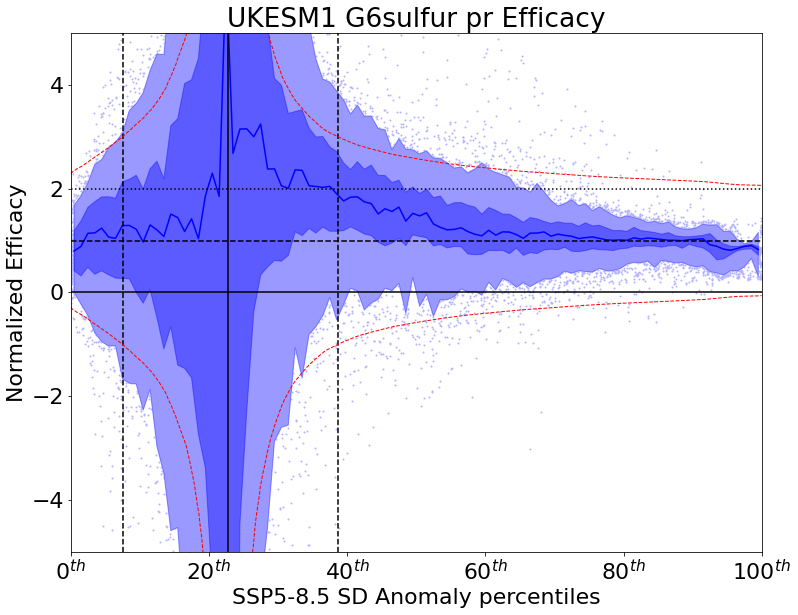

In [41]:
fig = plt.figure(1, figsize=(12, 9))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

plt.rcParams.update({'font.size': 22})

# plot efficacy for all points
plt.scatter(mltls_for_data_concat, eff_mltl_data_concat, s=1, color=(0.7, 0.7, 1.0))

# plot 5-95%ile range for efficacy
plot_5th = np.array([INNER[0] for INNER in eff_pctl_data_plot_pctls])
plot_95th = np.array([INNER[4] for INNER in eff_pctl_data_plot_pctls])
plt.fill_between(percentile_centres, plot_5th, plot_95th, color='w')
plt.fill_between(percentile_centres, plot_5th, plot_95th, color='b', alpha=0.4)
# plot 25-75%ile range for efficacy
plot_25th = np.array([INNER[1] for INNER in eff_pctl_data_plot_pctls])
plot_75th = np.array([INNER[3] for INNER in eff_pctl_data_plot_pctls])
plt.fill_between(percentile_centres, plot_25th, plot_75th, color='b', alpha=0.4)
# plot median efficacy
plot_50th = np.array([INNER[2] for INNER in eff_pctl_data_plot_pctls])
plt.plot(percentile_centres, plot_50th, color='b')

# plot horizonal zero line
plt.plot([0,1],[0,0],color='k')

# Plot milltile where zero crossed, and where GW signal is significant (normalized by SG signal strength)
if zero_pctl is not None:
    plt.plot([zero_pctl, zero_pctl],[-100,100],color='k')
if ttest_neg_pctl is not None:
    plt.plot([ttest_neg_pctl, ttest_neg_pctl],[-100,100],color='k', linestyle='dashed')
if ttest_pos_pctl is not None:
    plt.plot([ttest_pos_pctl, ttest_pos_pctl],[-100,100],color='k', linestyle='dashed')

# stat significant anomaly
zero_index = int(zero_pctl * 1000)
# plot negative efficacy significance threshold
plt.plot(milltile_centres[0:zero_index], (ttest_sds_orig / GW_mltl_data_medians)[0:zero_index], color='r', linewidth=1, linestyle='dashed')
plt.plot(milltile_centres[zero_index:], (-1.*ttest_sds_orig / GW_mltl_data_medians)[zero_index:], color='r', linewidth=1, linestyle='dashed')
# plot positive efficacy significance threshold
eff_thresh = 2.
plt.plot(milltile_centres[0:zero_index], -1. * ((-1. * eff_thresh * GW_mltl_data_medians + ttest_sds_orig) / GW_mltl_data_medians)[0:zero_index], color='r', linewidth=1, linestyle='dashed')
plt.plot(milltile_centres[zero_index:], ((eff_thresh * GW_mltl_data_medians + ttest_sds_orig) / GW_mltl_data_medians)[zero_index:], color='r', linewidth=1, linestyle='dashed')
    
# Efficacy of 1, 2 lines:
plt.plot([0,1],[1,1], color='k', linestyle='dashed')
plt.plot([0,1],[2,2], color='k', linestyle='dotted')

# set plot limits
plt.xlim([0,1])
plt.ylim([-5,5])

# set x-axis labels
plt.xticks(ticks=[0,0.2,0.4,0.6,0.8,1.0], labels=['0$^{th}$', '20$^{th}$', '40$^{th}$', '60$^{th}$', '80$^{th}$', '100$^{th}$'])

# label X and Y axes
plt.xlabel('SSP5-8.5 SD Anomaly percentiles')
plt.ylabel('Normalized Efficacy')
plt.title('UKESM1 '+exp+' '+var+' Efficacy')

plt.savefig('plots/'+var+'_'+exp+'_percentile_efficacy_plot.png')

In [42]:
# """
# Original data_dict code block
# """

# # Create an empty dictionary to store the data
# data_dict = {}

# # Loop over all variables, catching the "domain" value stored in the var_settings_dict
# for var, domain in var_settings_dict.items():
    
#     # Loop over all experiments, catching the settings stored in exp_settings_dict
#     for exp, exp_settings in exp_settings_dict.items():
    
#         # Now I unpack the 2 values stored in exp_settings into two variables
#         project, dates = exp_settings
        
#         # get the mean and standard deviation using get_ens_seasonal_mean_std()
#         # all the inputs needed for the function have been specified above except for:
#         # VAR and DOMAIN which are specified by the outer for loop, and
#         # EXP, PROJECT and DATES which are specified by the inner for loop
#         ds_mean, ds_std = get_ens_seasonal_mean_std(season, dates, data_dir, model, centre, var, domain, exp, project, runs, grid, time_files=time_files)
        
#         # Here the "key" for the dictionary has 3 parts: var, exp, and then 'mean' or 'std'
#         data_dict[var, exp, 'mean'] = ds_mean[var]
#         data_dict[var, exp, 'std'] = ds_std[var]
        
#     # end for exp
    
# #end for exp

# """
# Now we have a dictionary where every item is a data array
# """